<h3><center>Федеральное государственное бюджетное образовательное учреждение
<center>высшего образования
<center>"Финансовый университет при Правительстве 
<center>Российской Федерации"
<center>Департамент анализа данных и машинного обучения

<h3><center>Курсовая работа
<center>по дисциплине "Машинное обучение" 
<center>на тему: 
<center>"Использование методов машинного обучения для решения задачи выделения атрибутов товаров из текста"<center>

## ***<center> Введение***

####  _В современном мире с ростом электронной коммерции объемы информации о товарах, представленных в интернет-магазинах, постоянно увеличиваются. Для упрощения и ускорения поиска необходимой информации покупателями и снижения нагрузки на персонал магазинов, возникает задача автоматического выделения атрибутов товаров из описаний их характеристик, содержащихся в текстовых полях. Решение этой задачи с помощью методов машинного обучения может значительно упростить процесс поиска и сравнения товаров, а также повысить качество рекомендаций, которые система может предложить покупателю. В данной курсовой работе будет рассмотрено применение методов машинного обучения для решения задачи выделения атрибутов товаров из текстовых данных, различные подходы к решению задачи, оценены их достоинства и недостатки, а также проведено сравнение полученных результатов._

### ***<center> Цель работы***

#### _Целью данной работы является исследование и применение методов машинного обучения для решения задачи выделения атрибутов товаров из текстовых данных, а также разработка и оценка моделей, способных автоматически извлекать необходимые сущности._

### ***<center> Задачи***

Задачи, которые будут решаться в рамках данной работы, включают в себя: 
+ Сбор и обработка данных 
+ Основы Natural Language Processing'а:
    + Нормализация (приведение слов к нижнему регистру, удаление всей пунктуации)
    + Лемматизация (удаление стоп, приведение слов к нормальной форме)
    + bow (bag-of-words) (векторизация)
    + токенизация по словам
+ Ручная разметка и сбор сэмпла
+ Обработка разметочной выборки
+ Обучение и подбор различных моделей машинного обучения
+ Тюн параметров этих моделей с помощью перебора (GridSearchCV)
+ Алгоритм ребалансировки классов 
+ Вывод результатов всех моделей

### ***<center> Содержание***

* [1. Importing](#1) 

* [2. Data Preprocessing](#2)


* [3. Normalization/Lemmatization](#3)

    
* [4. Markup](#4)

* [5. Creating a sample](#5)


* [6. Markup Preprocessing](#6)


* [7. Vectorization](#7)


* [8. Model Training](#8)

* [9. Grid Search](#9)
    * [9.1. Logistic Regression](#9.1)
    * [9.2. Random Forest](#9.2)
    * [9.3. Support Vector Machine](#9.3)
    
* [10. Oversampling](#10)
    * [10.1. Logistic Regression](#10.1)
    * [10.2. Finish Result](#10.2)

* [11.Demonstration of results](#11)

* [12.The simplest neural network](#12)

* [13.Conclusion](#13)

<a id="1"></a>
# <b>1 <span style='color:#43a842'>|</span> Importing</b>
* [Оглавление](#0)

Импорт библиотек для работы с данными и построения моделей машинного обучения.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re

import pymorphy2
import nltk
from nltk.corpus import stopwords

from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

<a id="2"></a>
## <b>2 <span style='color:#43a842'>|</span> Data Preprocessing</b>
* [Оглавление](#0)

Загрузка исходного датасета и приведение его в читаемый вид, посредству удаления лишних столбцов и удаления строк с пропущенными значениями.

In [ ]:
first_df = pd.read_json('/content/drive/MyDrive/supl_biz_157k.json')
first_df.head(2)

,ID,Title,Price,Presence,Goods_rating,Info,Nesting_type_tags,Provider,Provider_address,Last_provider_activity,Link_to_provider,Link_to_good,Attached_files
0,9513200,Доска пола; Имитация бруса; Блок-хаус; Декинг;...,33 800 руб.,В наличии,Популярный товар,"[Толщина (мм): 20/45, ширина (мм): 90/135/140,...","[Товары и услуги, Строительные материалы, Пого...","Сибирский лес, торгово-строительная компания (...","Барнаул, г.Новоалтайск, ул.Промплощадка,13а",Был на сайте 31.10.2022,https://supl.biz/profiles/1223111/,https://supl.biz/doska-pola-imitatsiya-brusa-b...,NaN
1,26390427,"Вагонка, блок хаус, доска пола, строганная дос...",Цена по запросу,В наличии,Популярный товар,"[Продаем погонажные изделия хвойных пород, шир...","[Товары и услуги, Строительные материалы, Пого...",ООО Лестех43,Киров,Был на сайте 18.10.2022,https://supl.biz/profiles/1983162/,https://supl.biz/vagonka-blok-haus-doska-pola-...,https://suplbiz-a.akamaihd.net/media/proposals...


In [ ]:
first_df.Title.values[:60]

array(['Доска пола; Имитация бруса; Блок-хаус; Декинг; Строган.доска (сосна)',
       'Вагонка, блок хаус, доска пола, строганная доска, имитация бруса.',
       'Погонажные изделия, вагонка, евровагонка, имитация бруса, доска пола, строганная доска',
       'Технические входные двери',
       'Тротуарная плитка Искусственный камень',
       'Кровельные и стеновые сэндвич-панели',
       'Стеновые панели из массива',
       'Сэндвич-панели стеновые, сэндвич-панели кровельные',
       'Облицовочный кирпич', 'Стеновые панели КИРПИЧИКИ',
       'сэндвич панель стеновая',
       'Облицовочный камень Старый кирпич 210х60)',
       'Керамический кирпич облицовочный.',
       'Керамический облицовочный кирпич Маттоне Латерра Пшеница',
       'Газосиликатные блоки, пенобетонный блоки,кирпич керамический, кирпич силикатный, кирпич декоративный, керамзит оптом и в розницу с доставкой на объект',
       'Сэндвич-панели Стеновые', 'Облицовочный кирпич: Рваный камень',
       'Стеновые сэндвич-пане

In [ ]:
first_df.shape[0]

157068

In [ ]:
friendly_df = first_df[['Title', 'Info']]

In [ ]:
friendly_df.dropna(inplace=True)

In [ ]:
friendly_df.head(1)

,Title,Info
0,Доска пола; Имитация бруса; Блок-хаус; Декинг;...,"[Толщина (мм): 20/45, ширина (мм): 90/135/140,..."


Базовая предобработка и трансформация датасета в удобный вид

<a id="3"></a>
## <b>3 <span style='color:#43a842'>|</span> Normalization/Lemmatization </b>
* [Оглавление](#0)

> Нормализация (Normalization) в NLP (Natural Language Processing) — это процесс приведения текста к стандартному или нормализованному виду.
Процесс нормализации включает в себя различные шаги, такие как удаление знаков препинания, приведение всех символов к нижнему регистру, замена чисел на слова, удаление стоп-слов, лемматизация, стемминг и другое. 

##### Первый этап нормализации текста - удаление всех знаков препинания, при помощи регулярных выражений и лямбда-функций.

In [ ]:
friendly_df['Title'] = friendly_df['Title'].apply(
    lambda x: 
    re.sub(r'[^\w\s]', '', x)
)

In [ ]:
friendly_df.head(1)

,Title,Info
0,Доска пола Имитация бруса Блокхаус Декинг Стро...,"[Толщина (мм): 20/45, ширина (мм): 90/135/140,..."


Модуль, который используется для лемматизации и морфологического анализа слов в русском языке. Он предоставляет набор инструментов для получения грамматических характеристик слова (род, число, падеж, время и т.д.), а также его базовой формы (леммы).

In [ ]:
morph = pymorphy2.MorphAnalyzer()

С помощью модуля nltk были загружены стоп-слова из русского языка. Stop words - это часто встречающиеся в текстах слова, которые не несут смысловой нагрузки и могут быть исключены из анализа текста, чтобы уменьшить размерность признаков и повысить точность анализа.

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanlopatkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Второй этап – приведения всех символов к нижнему регистру, а также удаления всех стоп-слов с помощью lambda function.

In [ ]:
friendly_df['Title'] = friendly_df['Title'].apply(
    lambda x:
    ' '.join([word.lower() for word in x.split() if not word in stop_words and len(word) > 2])
)

In [ ]:
friendly_df.head()

,Title,Info
0,доска пола имитация бруса блокхаус декинг стро...,"[Толщина (мм): 20/45, ширина (мм): 90/135/140,..."
1,вагонка блок хаус доска пола строганная доска ...,"[Продаем погонажные изделия хвойных пород, шир..."
2,погонажные изделия вагонка евровагонка имитаци...,[Собственное производство в Архангельской обла...
3,технические входные двери,[Двери входные технические металлические для ...
4,тротуарная плитка искусственный камень,[Компания ООО Ингстром производит тротуарную п...


##### Третий – сама лемматизация. Лемматизация — это процесс приведения слова к его базовой форме (лемме), которая может быть использована для поиска, сравнения и анализа текста.

In [ ]:
friendly_df['Norm_Title'] = friendly_df['Title'].apply(
    lambda x: 
    [morph.parse(token)[0].normal_form for token in x.split()]
)

In [ ]:
friendly_df['Title'][200], friendly_df['Norm_Title'][200]

('Открою ключ интернетмагазин морепродуктов дней',
 ['откроить', 'ключ', 'интернетмагазин', 'морепродукт', 'день'])

<a id="4"></a>
## <b>4 <span style='color:#43a842'>|</span> Markup </b>
* [Оглавление](#0)

Так как датасет был неоднородным, из-за отсутствия единого шаблона описания, которое обуславливается их написанием большим кругом людей, алгоритмически сформировать сэмпл для фита в модель было непростой, а самое главное очень трудоемкой задачей, было принято решение обрабатывать названия товаров и самостоятельно выделять атрибуты к каждому слову. Все пары «слово из названия»: «соответствующий атрибут» были помещены в словари (для каждой строки исходного датасета свой словарь).

In [ ]:
friendly_df['markup'] = pd.Series(np.nan)

In [ ]:
def razmetka(indexs : list, df):
    copy = df.copy()
    i = indexs[0]
    ser = df.markup
    while i != indexs[1]:
            title = df.loc[float(str(i))].Norm_Title
            print('Название: ', *title)
            s = input()
            if s.lower() == 'стоп':
                df['markup'] = ser
                flag = False
                break
            elif s.lower() == 'скип':
                i +=1
                continue
            else:

                s = s.split()
                if len(s) != len(title) and s[-1] != '1':
                    print('Не все значение размечены')
                elif s[-1] == '1':
                    s = s + ['-'] * (len(title) - len(s))
                    ser[i] = str(dict(zip(title, s)))
                    i +=1

                else:
                    ser[i] = str(dict(zip(title, s)))
                    i +=1
    df['markup'] = ser

In [ ]:
friendly_df.shape

(157067, 4)

The first test of markup

In [ ]:
import random
while True:
    number = random.randint(0, friendly_df.shape[0])
    razmetka([number, number + 1], friendly_df)

Название:  станция насосный


 тов назн


Название:  валик 640100 56889 полиакрил зелёный ворс15мм100 maxitool


 стоп


Название:  кондиционер energolux sas07bd1altsau07bd1altws30


Process SpawnPoolWorker-60:
Process SpawnPoolWorker-59:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ivanlopatkin/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ivanlopatkin/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ivanlopatkin/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ivanlopatkin/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ivanlopatkin/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/ivanlopatkin/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/ivanlopatkin/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 364

KeyboardInterrupt: Interrupted by user

##### Import of markup by Ustinov Kirill Evgenievich (Было согласовано с Никитой Владимировичем)

In [ ]:
half_metka = pd.read_json('/Users/ivanlopatkin/Downloads/23_04.json')

In [ ]:
half_metka.head()

,Info,Norm_Title,Razme4
0,"[Толщина (мм): 20/45, ширина (мм): 90/135/140,...","[доска, пол, имитация, брус, блокхаус, декинг,...",None
1,"[Продаем погонажные изделия хвойных пород, шир...","[вагонка, блок, хаус, доска, пол, строгать, до...",None
2,[Собственное производство в Архангельской обла...,"[погонажный, изделие, вагонка, евровагонка, им...",None
3,[Двери входные технические металлические для ...,"[технический, входной, дверь]",None
4,[Компания ООО Ингстром производит тротуарную п...,"[тротуарный, плитка, искусственный, камень]",None


In [ ]:
with_metka = half_metka[half_metka.Razme4.isna() == False]

In [ ]:
for i in with_metka.iterrows():
    print(i[1][2])

{'аквавошер': 'тов', 'clean': 'бренд', 'cube': 'бренд', 'рro': 'бренд', 'для': '-', 'стиральный': 'назн', 'машина': '-'}
{'жёсткий': 'тов', 'диск': 'тов', '500': '-', 'гб': 'раз'}
{'жёсткий': 'тов', 'диск': 'тов', '1x2tb': 'раз', 'sata': 'бренд', 'гарантия': '1', '1': '-', 'год': '-'}
{'заправка': 'тов', 'картридж': 'тов', 'cf212a': 'бренд', 'hp': 'бренд'}
{'заправка': 'тов', 'картридж': 'тов'}
{'тэн': 'тов', 'стиральный': 'назн', 'машина': 'тов', 'универсальный': '-', '1700w': 'разм'}
{'запчасть': 'тов', 'для': '-', 'бытовой': 'наз', 'техника': 'тов'}
{'ремонт': 'тов', 'стиральный': 'наз', 'машина': 'тов', 'indesit': 'бренд', 'индезита': 'бренд'}
{'фильтр': 'тов', 'для': '-', 'вода': '-', 'посудомоечный': 'назн', 'и': '-', 'стиральный': 'наз', 'машина': '-', 'ariston': 'бренд', '91845': '-'}
{'стиральный': 'назн', 'машина': 'тов', 'indesit': 'бренд', 'iwuc': '1', '4105': '-'}
{'жёсткий': 'тов', 'диск': 'тов', 'toshiba': 'бренд', 'p300': '-'}
{'заправка': 'тов', 'картридж': 'тов'}
{'за

##### Моя часть разметки (после перезапуска ячеек слетели input'ы, именно из-за этого через 3 ячейки я закоммитился)

In [ ]:
import random
while True:
    number = random.randint(0, 104000)
    razmetka([number, number + 1], half_metka)

NameError: name 'razmetka' is not defined

In [ ]:
with_metka = half_metka[half_metka.Razme4.isna() == False]
with_metka.shape

(166, 3)

Всего было размечено 282 тайтла, исходя из которых был сформирован сэмпл из 600 наблюдений.

Сохранение данных для дальнейшего использования

In [ ]:
with_metka.to_csv('282_mechennih')

In [11]:
with open('/content/drive/MyDrive/282_mechennih_js', 'r', encoding='utf-8') as f:
    with_metka = json.load(f)

<a id="5"></a>
## <b>5 <span style='color:#43a842'>|</span> Creating a sample </b>
* [Оглавление](#0)

При создании итоговой выборки была проведена итерация по всем словарям, в ходе которых значения в них были распакованы и разбросаны в 2 списка: фича, таргет. 

In [12]:
df = pd.DataFrame({'Sentence': [], 'Token': [], 'Tag': []})
count = 0
tag_list, target_list, sentence = [], [], []
for i in with_metka['Razme4'].values():
    if len(i) in (np.arange(38, 10**3)):
        continue
    count += 1
    for key, value in dict(i).items():
        tag_list.append(value)
        target_list.append(key)
        sentence.append(count)

In [13]:
df.Token = target_list
df.Sentence = sentence
df.Tag = tag_list

In [14]:
df.head()

,Sentence,Token,Tag
0,1,аквавошер,тов
1,1,clean,бренд
2,1,cube,бренд
3,1,рro,бренд
4,1,для,-


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.groupby('Sentence').agg({'Tag': 'count'}).sort_values('Tag')

,Tag
Sentence,
65,2
66,2
31,2
29,2
41,2
...,...
120,14
157,15
76,16


In [109]:
class Sentence_getter(object):
    def __init__(self, data):
        self.data = data
        agg_fun = lambda s: [(w, p) for w, p in zip(s["Token"].values.tolist(),
                                                       s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence').apply(agg_fun)
        self.sentences = [i for i in self.grouped]

In [110]:
getter = Sentence_getter(df)

In [111]:
sentences = getter.sentences

In [112]:
sentences[0]

[('аквавошер', 'тов'),
 ('clean', 'бренд'),
 ('cube', 'бренд'),
 ('рro', 'бренд'),
 ('для', '-'),
 ('стиральный', 'назн'),
 ('машина', '-')]

In [113]:
words = list(set(df["Token"].values))
tags = list(set(df["Tag"].values))

In [114]:
# Creating vocabulary
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [115]:
tag2idx

{'бренд': 0,
 'мод': 1,
 'назн': 2,
 'тип': 3,
 'тов': 4,
 'мат': 5,
 '-': 6,
 'разм': 7}

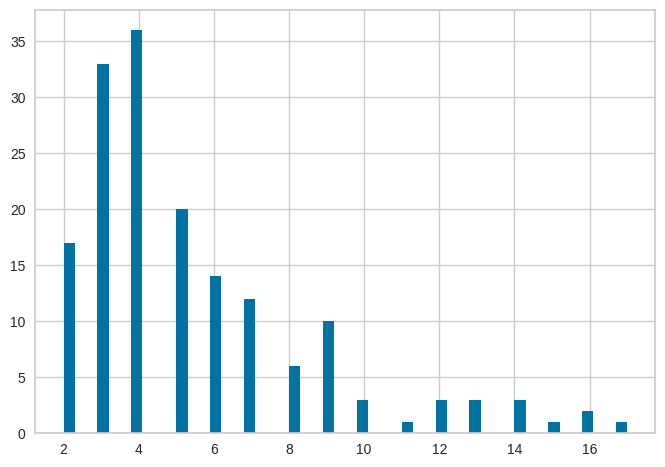

In [116]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [117]:
num_words = len(words)
num_tags = len(tags)
num_words

481

In [119]:
max_len = 20

X = [[word2idx[w[0]] for w in s] for s in sentences] # представление слов тайтла в соот-ие индексы
X = pad_sequences(maxlen = max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["-"])

One hot encoder

In [120]:
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [122]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)

model = Model(input_word, out)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 20, 20)            9620      
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 20, 20)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 200)          96800     
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 8)            1608      
 tributed)                                                       
                                                           

In [129]:
def f1_macro(y_train, y_pred):
    return f1_score(tensorflow.argmax(y_train, axis=1), tensorflow.argmax(y_pred, axis=1), average='macro')

In [123]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
             metrics=['accuracy'])

EarlyStopping в Keras позволяет остановить обучение модели, когда заданное метрическое значение перестает улучшаться

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

In [126]:
len(X_test), len(y_test)

(17, 17)

In [ ]:
model.evaluate(X_train, np.array(y_train))

In [128]:
model.evaluate(X_test, np.array(y_test))

1/1 [==============================] - 0s 46ms/step - loss: 1.8070 - accuracy: 0.8706


[1.806983470916748, 0.8705882430076599]

In [174]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 69ms/step


<a id="6"></a>
## <b>6 <span style='color:#43a842'>|</span> Markup Preprocessing</b>
* [Оглавление](#0)

На данном этапе работы были учтены все недочеты ручной разметки. Итоговая выборка очищенна и проанализирована на наличие дисбаланса классов. Можно увидеть, что классы не сбалансированы.

In [15]:
df.Tag.unique()

array(['тов', 'бренд', '-', 'назн', 'раз', '1', 'разм', 'наз', 'тип',
       'мат', 'гор', 'мод', 'товар', 'размер', 'материал', 'модель',
       'гост', 'цвет', 'бред'], dtype=object)

In [16]:
def replace_word(true_word, false_word):
    df.Tag = df.Tag.apply(lambda x: true_word if x == false_word else x)

In [17]:
replace_word('тов', 'товар')
replace_word('назн', 'наз')
replace_word('бренд', 'бред')
replace_word('мод', 'модель')
replace_word('мат', 'материал')
replace_word('разм', 'размер')
replace_word('разм', 'раз')
replace_word('-', '1')

In [18]:
df['Tag'].value_counts()

-        349
тов      188
тип       93
назн      82
разм      63
мод       53
бренд     40
мат       37
гор        3
гост       3
цвет       1
Name: Tag, dtype: int64

In [19]:
#df = df[df.Tag != '-']
df = df[df.Tag != 'гост']
df = df[df.Tag != 'цвет']
df = df[df.Tag != 'гор']

In [20]:
df['Tag'].value_counts()

-        349
тов      188
тип       93
назн      82
разм      63
мод       53
бренд     40
мат       37
Name: Tag, dtype: int64

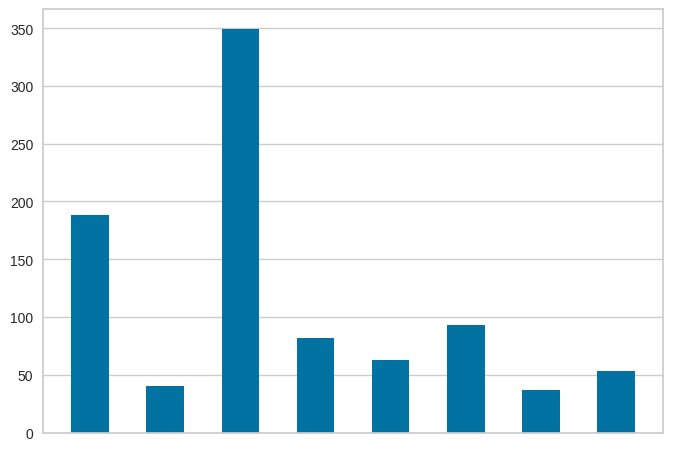

In [21]:
plt.hist(df['Tag'], bins=df['Tag'].nunique(), rwidth=0.5)
plt.xticks([])
plt.show()

<a id="7"></a>
## <b>7 <span style='color:#43a842'>|</span> Vectorization</b>
* [Оглавление](#0)

> Векторизация в NLP — это процесс преобразования текстовых данных в числовые векторы, которые могут быть использованы для обучения моделей машинного обучения или анализа текста. 
Существует несколько методов векторизации текста, но в данной работе был взят «мешок слов». Мешок слов (Bag-of-Words, BoW) — это метод, в котором каждое слово в тексте преобразуется в отдельный признак, а затем создается вектор, в котором каждый элемент соответствует количеству вхождений слова в тексте. Этот метод не учитывает порядок слов в тексте, но может быть эффективен для моделей, которые не требуют контекста

Разделение набора данных на обучающую и тестовую выборки и векторизации текстовых данных с использованием метода "мешка слов".

In [ ]:
y = df['Target']
X = df['Tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y)

Применен метод fit_transform() к корпусу текстов, который вернул матрицу bow, где каждый ряд соответствует документу, а каждый столбец - слову из корпуса.

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train)

Метод для получения словаря, который соотносит слова с их индексами в матрице признаков

In [ ]:
list(vec.vocabulary_.items())[:10]

[('картридж', 118),
 ('блок', 80),
 ('отопление', 153),
 ('б8', 77),
 ('line', 59),
 ('таможенный', 214),
 ('стиральный', 205),
 ('шпатель', 233),
 ('proff', 63),
 ('470', 34)]

<a id="8"></a>
## <b>8 <span style='color:#43a842'>|</span> Model Training</b>
* [Оглавление](#0)

Для суммарной оценки моделей был создан DataFrame, который иллюстрирует качество моделей, исходя из 3 метрик: accuracy, f1-macro и f1- weighted (взвешенное).

In [ ]:
def first_models(state, class_weight=None):
    global clf, dt, rf
    clf = LogisticRegression(random_state=state, max_iter=500, class_weight=class_weight).fit(bow, y_train)
    dt = DecisionTreeClassifier(random_state=state, class_weight=class_weight).fit(bow, y_train)
    rf = RandomForestClassifier(random_state=state, class_weight=class_weight).fit(bow, y_train)
    kn_clf = KNeighborsClassifier().fit(bow, y_train)
    svc = SVC(random_state=state, class_weight=class_weight).fit(bow, y_train)
    mlp = MLPClassifier(random_state=state).fit(bow, y_train)
    
    #print(classification_report(clf.predict(vec.transform(X_test)), y_test))
    
    df_metrics = pd.DataFrame({'Models': ['Logistic Regression',
                             'Decision Tree',
                             'Random Forest',
                             'K Neighbors',
                             'Support Vec', 
                             'MLP'],
                  'Accuracy': [accuracy_score(y_test, clf.predict(vec.transform(X_test))),
                              accuracy_score(y_test, dt.predict(vec.transform(X_test))),
                              accuracy_score(y_test, rf.predict(vec.transform(X_test))),
                              accuracy_score(y_test, kn_clf.predict(vec.transform(X_test))),
                              accuracy_score(y_test, svc.predict(vec.transform(X_test))), 
                              accuracy_score(y_test, mlp.predict(vec.transform(X_test)))],
                  'f1_macro': [f1_score(y_test, clf.predict(vec.transform(X_test)), average='macro'),
                              f1_score(y_test, dt.predict(vec.transform(X_test)), average='macro'),
                              f1_score(y_test, rf.predict(vec.transform(X_test)), average='macro'),
                              f1_score(y_test, kn_clf.predict(vec.transform(X_test)), average='macro'),
                              f1_score(y_test, svc.predict(vec.transform(X_test)), average='macro'),
                              f1_score(y_test, mlp.predict(vec.transform(X_test)), average='macro')],
                  'f1_weighted': [f1_score(y_test, clf.predict(vec.transform(X_test)), average='weighted'),
                              f1_score(y_test, dt.predict(vec.transform(X_test)), average='weighted'),
                              f1_score(y_test, rf.predict(vec.transform(X_test)), average='weighted'),
                              f1_score(y_test, kn_clf.predict(vec.transform(X_test)), average='weighted'),
                              f1_score(y_test, svc.predict(vec.transform(X_test)), average='weighted'),
                              f1_score(y_test, mlp.predict(vec.transform(X_test)), average='weighted')]})
    
    return df_metrics

In [ ]:
without_cw = first_models(42)
without_cw

,Models,Accuracy,f1_macro,f1_weighted
0,Logistic Regression,0.525180,0.426566,0.477152
1,Decision Tree,0.568345,0.488456,0.587650
2,Random Forest,0.525180,0.434610,0.476380
3,K Neighbors,0.496403,0.395937,0.436911
4,Support Vec,0.532374,0.445701,0.488936
5,MLP,0.525180,0.434610,0.476380


In [ ]:
with_cw = first_models(42, 'balanced')
with_cw

,Models,Accuracy,f1_macro,f1_weighted
0,Logistic Regression,0.575540,0.493841,0.593597
1,Decision Tree,0.561151,0.504229,0.591235
2,Random Forest,0.525180,0.434610,0.476380
3,K Neighbors,0.496403,0.395937,0.436911
4,Support Vec,0.575540,0.493841,0.593597
5,MLP,0.525180,0.434610,0.476380


In [ ]:
(with_cw.f1_macro - without_cw.f1_macro) * 100

0    6.727516
1    1.577297
2    0.000000
3    0.000000
4    4.814026
5    0.000000
Name: f1_macro, dtype: float64

Исходя из данного фрейма можно сделать вывод о том, что логистическая регрессия, дерево решений, случайный лес, SVM и MLP показывают примерно одинаковую точность в данной задаче классификации, с точностью порядка 0.55. Однако, f1_macro и f1_weighted, показывают, что лучшие результаты по этим метрикам дает случайный лес. Ближайших соседей же показал себя намного хуже остальных моделей, что не удивительно, поскольку для данного классификатора нужен большой объем наблюдений.

# <a id="9"></a>
## <b>9 <span style='color:#43a842'>|</span> Grid Search</b>
* [Оглавление](#0)

> GridSearchCV - это метод поиска гиперпараметров, который позволяет автоматически перебирать все возможные комбинации заданных гиперпараметров модели и находить наилучшие значения гиперпараметров. Он позволяет выполнить перебор значений гиперпараметров и выбрать лучшие параметры для модели.

In [ ]:
def get_metrics(model, title):
    met = pd.DataFrame({'Models': [title], 
                            'Accuracy': accuracy_score(y_test, model.predict(vec.transform(X_test))), 
                            'f1_macro': f1_score(y_test, model.predict(vec.transform(X_test)), average='macro'), 
                            'f1_weighted': f1_score(y_test, model.predict(vec.transform(X_test)), average='weighted')})
    return met


In [ ]:
template = pd.DataFrame({'Models': [],
                              'Accuracy': [],
                              'f1_macro': [],
                              'f1_weighted': []})

In [ ]:
lr_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000], 
      "penalty": ['l1', 'l2', 'elasticnet'],
      "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

rf_grid = {
    'max_depth': range(1, 100), 
    'min_samples_split': range(1, 10),
    'max_features': ['sqrt']
}

dt_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [ ]:
def gridsearch(model, params, title):
    global template
    search = GridSearchCV(model, params, cv=5, scoring='f1_macro').fit(bow, y_train)
    best_lr = search.best_estimator_
    template = template.append(get_metrics(best_lr, title))

In [ ]:
titles = ['Remastered LR', 'Remastered RF', 'Remastered DT']
models = [clf, rf, dt]
grids = [lr_grid, rf_grid, dt_grid]

In [ ]:
for i in range(3):
    gridsearch(models[i], grids[i], titles[i])

In [ ]:
template

,Models,Accuracy,f1_macro,f1_weighted
0,Remastered LR,0.568345,0.515320,0.603790
0,Remastered RF,0.532374,0.474426,0.560141
0,Remastered DT,0.568345,0.488456,0.587650


# <a id="9.1"></a>
### <b>9.1 <span style='color:#43a842'>|</span> Logistic Regression</b>
* [Оглавление](#0)

In [ ]:
%%time
search = GridSearchCV(clf, params, cv=10, scoring='f1_macro').fit(bow, y_train)

CPU times: user 20.5 s, sys: 69.8 ms, total: 20.5 s
Wall time: 20.6 s


In [ ]:
search.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}

In [ ]:
best_lr = search.best_estimator_

In [ ]:
template = template.append(get_metrics(best_lr, 'Remastered LR'))

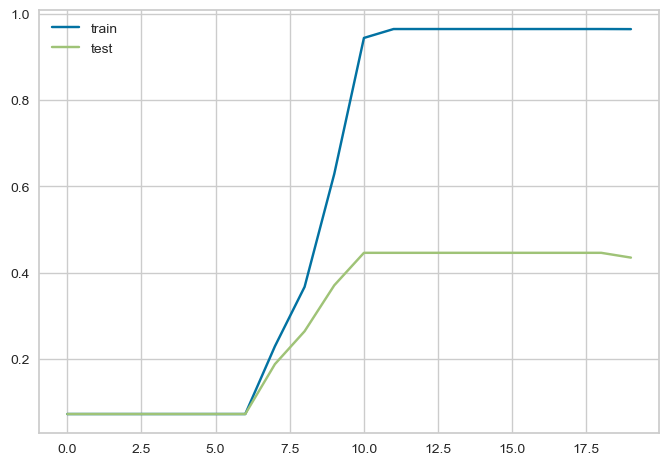

In [ ]:
trains = []
tests = []
for i in np.logspace(-3, 3, 20):
    lr = LogisticRegression(C=i).fit(bow, y_train)
    trains.append(f1_score(y_train, lr.predict(vec.transform(X_train)), average='macro'))
    tests.append(f1_score(y_test, lr.predict(vec.transform(X_test)), average='macro'))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

# <a id="9.2"></a>
### <b>9.2 <span style='color:#43a842'>|</span> Random Forest</b>
* [Оглавление](#0)

In [ ]:
params = {'max_depth': range(1, 100), 'min_samples_split': range(1, 10)}

In [ ]:
%%time
search = RandomizedSearchCV(rf, params, cv=5, scoring='f1_macro').fit(bow, y_train)

CPU times: user 5.28 s, sys: 71.6 ms, total: 5.35 s
Wall time: 5.36 s


In [ ]:
search.best_params_

{'min_samples_split': 4, 'max_depth': 87}

In [ ]:
best_rf = search.best_estimator_

In [ ]:
template = template.append(get_metrics(best_rf, 'Remastered RF'))

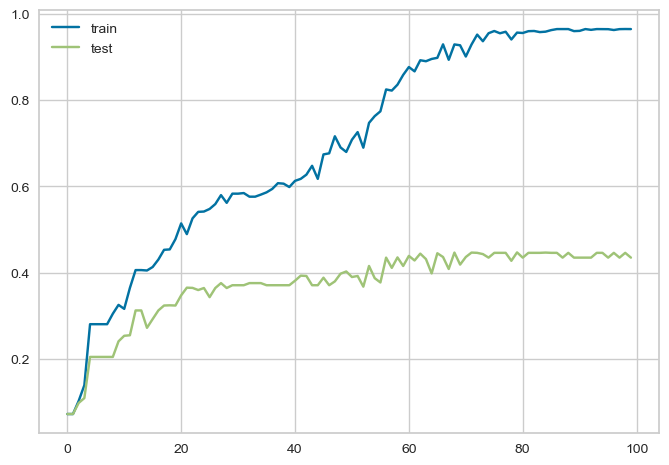

In [ ]:
trains = []
tests = []
for depth in np.linspace(1, 101, 100):
    rf = RandomForestClassifier(max_depth=depth).fit(bow, y_train)
    trains.append(f1_score(y_train, rf.predict(vec.transform(X_train)), average='macro'))
    tests.append(f1_score(y_test, rf.predict(vec.transform(X_test)), average='macro'))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

# <a id="9.3"></a>
### <b>9.3 <span style='color:#43a842'>|</span> Decision Tree</b>
* [Оглавление](#0)

In [ ]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}


In [ ]:
%%time
search = GridSearchCV(dt, params, cv=10, scoring='f1_macro').fit(bow, y_train)

CPU times: user 3.83 s, sys: 10.5 ms, total: 3.84 s
Wall time: 3.85 s


In [ ]:
search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
best_dt = search.best_estimator_

In [ ]:
template = template.append(get_metrics(best_dt, 'Remastered D Tree'))

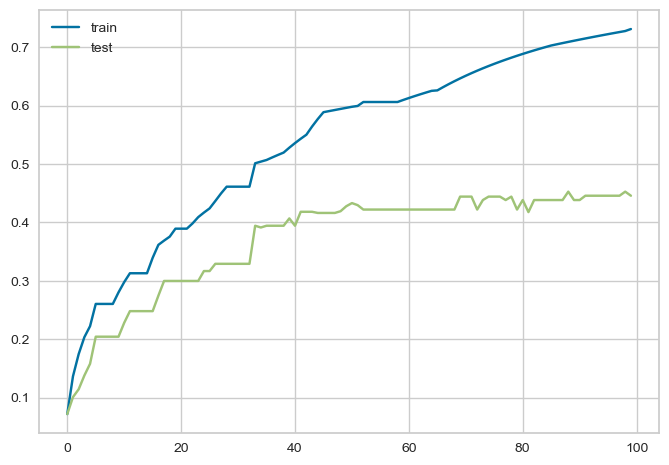

In [ ]:
trains = []
tests = []
for depth in np.linspace(1, 101, 100):
    dt = DecisionTreeClassifier(max_depth=depth).fit(bow, y_train)
    trains.append(f1_score(y_train, dt.predict(vec.transform(X_train)), average='macro'))
    tests.append(f1_score(y_test, dt.predict(vec.transform(X_test)), average='macro'))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

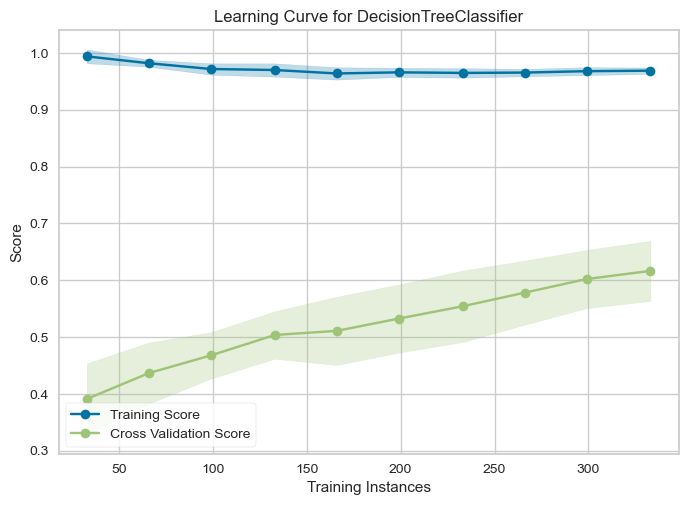

In [ ]:
visualizer = LearningCurve(
    DecisionTreeClassifier(random_state=42), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(bow, y_train).show() 

# <a id="10"></a>
## <b>10 <span style='color:#43a842'>|</span> Oversampling</b>
* [Оглавление](#0)

> Oversampling (увеличение выборки) - это техника балансировки классов, которая заключается в увеличении числа примеров меньшего класса, чтобы достичь более равномерного распределения классов в обучающей выборке.

In [ ]:
train_os = pd.DataFrame({'Token': X_train,
                        'Target': y_train})

In [ ]:
train_os.Target.value_counts()

тов      141
тип       70
назн      61
разм      47
мод       40
бренд     30
мат       28
Name: Target, dtype: int64

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(bow, y_train)

In [ ]:
oversample = LogisticRegression(random_state=42, class_weight='balanced').fit(X_resampled, y_resampled)

In [ ]:
y_pred = oversample.predict(vec.transform(X_test))
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       бренд       0.20      0.67      0.31         3
         мат       0.44      1.00      0.62         4
         мод       1.00      0.20      0.33        66
        назн       0.48      1.00      0.65        10
        разм       0.38      0.67      0.48         9
         тип       0.22      0.71      0.33         7
         тов       0.83      0.97      0.90        40

    accuracy                           0.57       139
   macro avg       0.51      0.75      0.52       139
weighted avg       0.80      0.57      0.53       139



In [ ]:
oversample_df = pd.DataFrame({'Models': [],
                              'Accuracy': [],
                              'f1_macro': [],
                              'f1_weighted': []})

In [ ]:
def train_for_model(model, df, title):
    clf = model.fit(X_resampled, y_resampled)
    y_pred = clf.predict(vec.transform(X_test))
    info = pd.DataFrame({'Models': [title],
                  'Accuracy': accuracy_score(y_test, y_pred),
                  'f1_macro': f1_score(y_test, y_pred, average='macro'),
                  'f1_weighted': f1_score(y_test, y_pred, average='weighted')})
    df = df.append(info)
    return df

In [ ]:
lr_info = train_for_model(LogisticRegression(random_state=42), oversample_df, 'OS Log Rega')
rf_info = train_for_model(RandomForestClassifier(random_state=42), lr_info, 'OS R Forest')
dt_info = train_for_model(DecisionTreeClassifier(random_state=42), rf_info, 'OS D Tree')

# Smote results

In [ ]:
dt_info

,Models,Accuracy,f1_macro,f1_weighted
0,OS Log Rega,0.568345,0.515320,0.603790
0,OS R Forest,0.539568,0.479798,0.581497
0,OS D Tree,0.532374,0.468708,0.568941


# My_oversampling

In [ ]:
train_os = pd.DataFrame({'Token': X_train,
                        'Target': y_train})

In [ ]:
rats = []
largest_class = train_os.Target.value_counts().max()
for i in train_os.Target.value_counts():
    rats.append(largest_class / i)
rats

[1.0,
 2.0142857142857142,
 2.3114754098360657,
 3.0,
 3.525,
 4.7,
 5.035714285714286]

In [ ]:
def oversampling(df, rats, *target):
    oversampl_df = df.loc[df.Target == 'тов']
    for i in range(len(target)):
        mask = df.loc[df.Target == target[i]]
        sampled_class = mask.loc[mask.index.repeat(int(rats[i + 1]))]
        oversampl_df = oversampl_df.append(sampled_class)
    return oversampl_df

In [ ]:
new_train_os = oversampling(train_os, rats, 'тип', 'назн', 'разм', 'мод', 'бренд', 'мат')
new_train_os.shape

(924, 2)

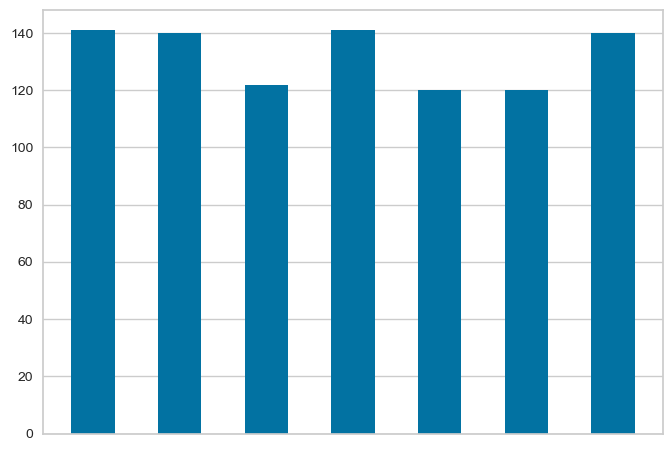

In [ ]:
plt.hist(new_train_os['Target'], bins=new_train_os['Target'].nunique(), rwidth=0.5)
plt.xticks([])
plt.show()

In [ ]:
y_os = new_train_os['Target']
X_os = new_train_os['Token']
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size = 0.25, random_state=42)

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1)) # строим BoW для слов
new_bow = vec.fit_transform(X_train_os)

In [ ]:
clf_os = LogisticRegression(random_state=42, class_weight='balanced').fit(new_bow, y_train_os)

##### Оценка модели по новой выборке

In [ ]:
y_pred = clf_os.predict(vec.transform(X_test_os))
print(classification_report(y_pred, y_test_os))

              precision    recall  f1-score   support

       бренд       1.00      1.00      1.00        26
         мат       1.00      0.90      0.95        39
         мод       1.00      0.81      0.90        32
        назн       0.89      1.00      0.94        33
        разм       0.90      1.00      0.95        35
         тип       0.80      0.65      0.72        37
         тов       0.76      1.00      0.87        29

    accuracy                           0.90       231
   macro avg       0.91      0.91      0.90       231
weighted avg       0.91      0.90      0.90       231



##### Оценка модели по первой выборке (несбалансированной)

In [ ]:
y_predicted = clf_os.predict(vec.transform(X_test))
print(classification_report(y_predicted, y_test))

              precision    recall  f1-score   support

       бренд       0.20      0.67      0.31         3
         мат       0.44      1.00      0.62         4
         мод       0.08      0.25      0.12         4
        назн       0.48      1.00      0.65        10
        разм       0.38      0.67      0.48         9
         тип       0.78      0.25      0.38        71
         тов       0.81      1.00      0.89        38

    accuracy                           0.57       139
   macro avg       0.45      0.69      0.49       139
weighted avg       0.70      0.57      0.55       139



In [ ]:
def train_for_model(model, df, title):
    clf = model.fit(new_bow, y_train_os)
    y_pred = clf.predict(vec.transform(X_test))
    info = pd.DataFrame({'Models': [title],
                  'Accuracy': accuracy_score(y_test, y_pred),
                  'f1_macro': f1_score(y_test, y_pred, average='macro'),
                  'f1_weighted': f1_score(y_test, y_pred, average='weighted')})
    df = df.append(info)
    return df

In [ ]:
lr_info = train_for_model(LogisticRegression(random_state=42), oversample_df, 'OS Log Rega')
lr_info

,Models,Accuracy,f1_macro,f1_weighted
0,OS Log Rega,0.568345,0.491855,0.591404


С oversampling'ом

In [ ]:
rf_info = train_for_model(RandomForestClassifier(random_state=42), lr_info, 'OS R Forest')
rf_info

,Models,Accuracy,f1_macro,f1_weighted
0,OS Log Rega,0.568345,0.491855,0.591404
0,OS R Forest,0.568345,0.491855,0.591404


# <a id="11"></a>
### <b>11<span style='color:#43a842'>|</span> Demonstration of results</b>
* [Оглавление](#0)

В данном блоке работы была разработана функция, принимающая абсолютно любое название товара и делает предикт для каждого токена в нем. Строка нормализуется и идет в предикт уже готового классификатора.

In [ ]:
def predict(title):
    
    title = re.sub(r'[^\w\s]', '', title)
    title = [word.lower() for word in title.split() if not word in stop_words and len(word) > 2]
    norm_title = [morph.parse(token)[0].normal_form for token in title]
    print('Normolized title:', norm_title)
    
    X = pd.Series(norm_title)
    print(f'Predicted values:{clf.predict(vec.transform(X))}')

In [ ]:
predict('Погонажные изделия, вагонка, евровагонка, имитация бруса, доска пола, строганная доска')

Normolized title: ['погонажный', 'изделие', 'вагонка', 'евровагонка', 'имитация', 'брус', 'доска', 'пол', 'строгать', 'доска']
Predicted values:['тип' 'тов' 'тип' 'тип' 'тип' 'тип' 'тип' 'тип' 'тип' 'тип']


# <a id="12"></a>
### <b>12<span style='color:#43a842'>|</span> The simplest neural network</b>
* [Оглавление](#0)

Для того, чтобы убедиться в том, что машинное обучение в чистом виде плохо себе показывает в задачах Named-entity recognition, было проведено исследование самой базовой модели нейронной сети. Для ее создания использовался пакет Tensor Flow и входящий в него Keras.

In [22]:
class Sentence_getter(object):
    def __init__(self, data):
        self.data = data
        agg_fun = lambda s: [(w, p) for w, p in zip(s["Token"].values.tolist(),
                                                       s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence').apply(agg_fun)
        self.sentences = [i for i in self.grouped]

In [23]:
getter = Sentence_getter(df)

Создание списков из zip с атрибутами и самим токеном для каждого товара

In [24]:
sentences = getter.sentences

In [25]:
sentences[0]

[('аквавошер', 'тов'),
 ('clean', 'бренд'),
 ('cube', 'бренд'),
 ('рro', 'бренд'),
 ('для', '-'),
 ('стиральный', 'назн'),
 ('машина', '-')]

In [26]:
words = list(set(df["Token"].values))
tags = list(set(df["Tag"].values))

Для каждого уникального токена/тэга задаются соответсвующие уникальные индексы

In [27]:
# Creating vocabulary
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [28]:
tag2idx

{'мод': 0,
 'бренд': 1,
 'разм': 2,
 'тип': 3,
 'тов': 4,
 'мат': 5,
 'назн': 6,
 '-': 7}

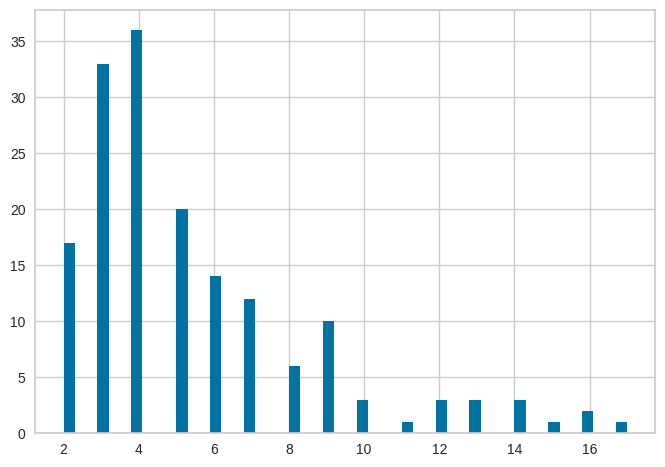

In [29]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [30]:
num_words = len(words)
num_tags = len(tags)
num_words

481

In [31]:
max_len = 20

X = [[word2idx[w[0]] for w in s] for s in sentences] # представление слов тайтла в соот-ие индексы
X = pad_sequences(maxlen = max_len, sequences=X, padding='post', value=num_words-1)  # формирование матрицы, при помощи добавления последнего индекса до того момента, пока длина листа не будет 20

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["-"])

One hot encoder. Преобразует целочисленные метки классов в бинарную матрицу, где каждая метка класса представлена в виде вектора с единицей в соответствующем индексе класса

In [32]:
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

Описание архитектуры нейронной сети.

In [34]:
input_word = Input(shape=(max_len,)) # создается входной слой с заданной формой 
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word) #Слой отображает целые числа (входные индексы слов) в плотные векторы фиксированной размерности
model = SpatialDropout1D(0.1)(model) #регуляризацию модели путем случайного обнуления (dropout) некоторых выходных признаков на уровне фичей входной последовательности
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model) #слой, который позволяет модели улавливать и использовать информацию из прошлых и будущих состояний последовательности
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model) #позволяет применить плотный слой ко всем временным шагам (выходам) предыдущего слоя

model = Model(input_word, out) # экземпляр модели, определяющий входной и выходной слои
model.summary() #сводка

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 20)            9620      
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 20)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 20, 200)          96800     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 20, 8)            1608      
 ibuted)                                                         
                                                             

In [ ]:
def f1_macro(y_train, y_pred):
    return f1_score(tensorflow.argmax(y_train, axis=1), tensorflow.argmax(y_pred, axis=1), average='macro')

In [35]:
#для компиляции модели в Keras после ее определения
model.compile(optimizer='adam',loss='categorical_crossentropy',
             metrics=['accuracy'])

EarlyStopping в Keras позволяет остановить обучение модели, когда заданное метрическое значение перестает улучшаться

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

In [39]:
len(X_test), len(y_test)

(17, 17)

In [ ]:
model.evaluate(X_train, np.array(y_train))

In [ ]:
model.evaluate(X_test, np.array(y_test))

1/1 [==============================] - 0s 46ms/step - loss: 1.8070 - accuracy: 0.8706


[1.806983470916748, 0.8705882430076599]

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 69ms/step


<a id="13"></a>
## <b>13<span style='color:#43a842'>|</span> Сonclusion</b>
* [Оглавление](#0)

Из-за недостаточного количества данных в задаче, любой перекос в сторону одного из классов оказывался критическим. 
Для преодоления этой проблемы было принято решение максимально расширить все классы путем добавления n_i chunks по таргету, 
где n_i = int((shape[0] самого большого класса) / (shape[0] i-го класса)). После обучения модели на такой выборке был получен довольно неплохой результат на изначальной тестовой выборке, которая была несбалансированной. Были изучены различные методы борьбы с недостатком данных и дисбалансом классов, и была подобрана оптимальная модель для решения задачи многоклассовой классификации с помощью логистической регрессии. Также был проведен анализ NER модели, при помощи Keras и рекуррентной нейронной сети, данная модель показала себя лучше всего, что неудивительно, ведь порядок слов в названии играет огромную роль в задачах NER.